In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('../Tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,3.486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,6.837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,7.033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.shape

(14640, 15)

<Axes: xlabel='airline_sentiment', ylabel='count'>

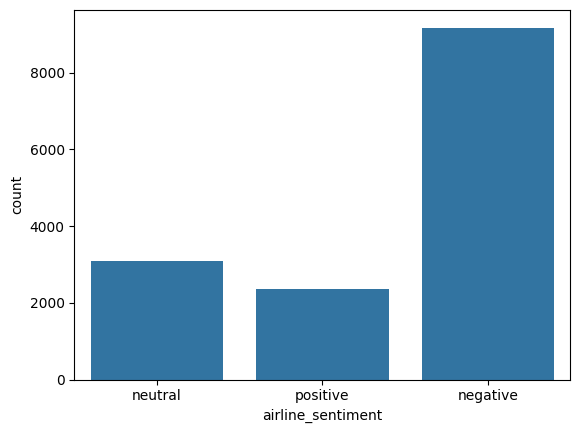

In [6]:
sns.countplot(x='airline_sentiment', data=df)

**Pré-Processamento**

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [10]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica dhepburn said
1,570301130888122368,positive,3.486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus youve added commercial expe...
2,570301083672813571,neutral,6.837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica didnt today must mean need take ...
3,570301031407624196,negative,1.0,Bad Flight,7.033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing


<Axes: xlabel='airline_sentiment', ylabel='count'>

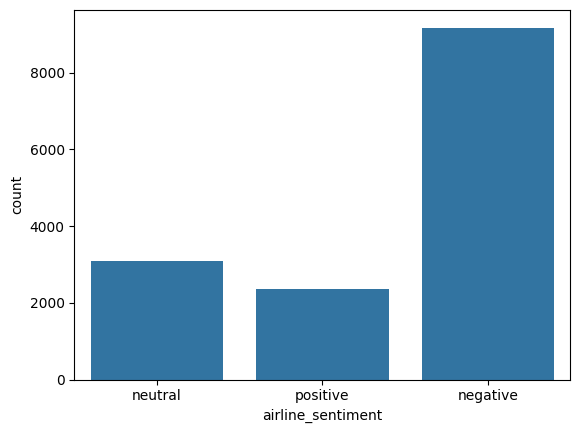

In [11]:
sns.countplot(x="airline_sentiment", data=df) # validando se mudou as classes

In [12]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['airline_sentiment'])

In [13]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [14]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [16]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [18]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


330/330 ━━━━━━━━━━━━━━━━━━━━ 82s 221ms/step - accuracy: 0.6296 - loss: 0.8986 - val_accuracy: 0.6664 - val_loss: 0.7779
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 100s 276ms/step - accuracy: 0.7558 - loss: 0.6000 - val_accuracy: 0.7713 - val_loss: 0.5498
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 120s 209ms/step - accuracy: 0.8338 - loss: 0.4318 - val_accuracy: 0.7551 - val_loss: 0.5701
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - accuracy: 0.8641 - loss: 0.3566 - val_accuracy: 0.7782 - val_loss: 0.5675
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.8874 - loss: 0.3056 - val_accuracy: 0.7790 - val_loss: 0.5985
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 72s 218ms/step - accuracy: 0.9063 - loss: 0.2672 - val_accuracy: 0.7739 - val_loss: 0.6790
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 74s 224ms/step - accuracy: 0.9170 - loss: 0.2319 - val_accuracy: 0.7705 - val_loss: 0.7104
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 75s 227ms/step - accuracy: 0.9287 - loss: 0.2034 - v

**OVERSAMPLING**

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)  # Define um estado aleatório para reprodutibilidade
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_pad, y_train)

In [20]:
# treino do modelo com os dados desbalanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 130s 212ms/step - accuracy: 0.9291 - loss: 0.2183 - val_accuracy: 0.9470 - val_loss: 0.1875
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 112s 182ms/step - accuracy: 0.9536 - loss: 0.1488 - val_accuracy: 0.9657 - val_loss: 0.1335
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 113s 184ms/step - accuracy: 0.9652 - loss: 0.1146 - val_accuracy: 0.9657 - val_loss: 0.1153
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 117s 189ms/step - accuracy: 0.9712 - loss: 0.0955 - val_accuracy: 0.9739 - val_loss: 0.0936
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 154s 210ms/step - accuracy: 0.9760 - loss: 0.0824 - val_accuracy: 0.9753 - val_loss: 0.0709
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 121s 197ms/step - accuracy: 0.9769 - loss: 0.0758 - val_accuracy: 0.9698 - val_loss: 0.1072
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 122s 199ms/step - accuracy: 0.9808 - loss: 0.0637 - val_accuracy: 0.9835 - val_loss: 0.0626
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 124s 202ms/step - accuracy: 0.9840 -

<Axes: xlabel='label_encoded', ylabel='count'>

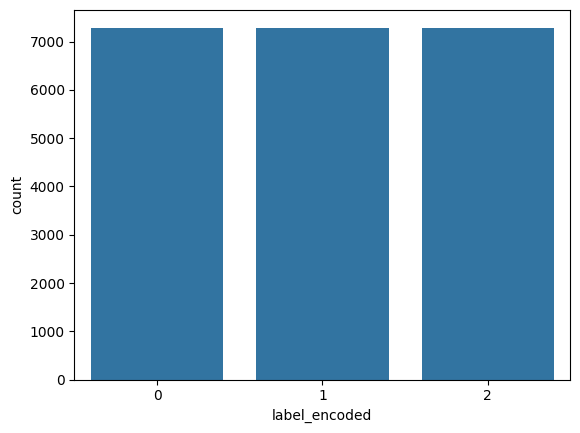

In [21]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [22]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1889
           1       0.52      0.55      0.53       580
           2       0.65      0.66      0.66       459

    accuracy                           0.75      2928
   macro avg       0.67      0.68      0.68      2928
weighted avg       0.75      0.75      0.75      2928



In [23]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.7483
Precisão: 0.7526
Recall: 0.7483
F1-Score: 0.7503


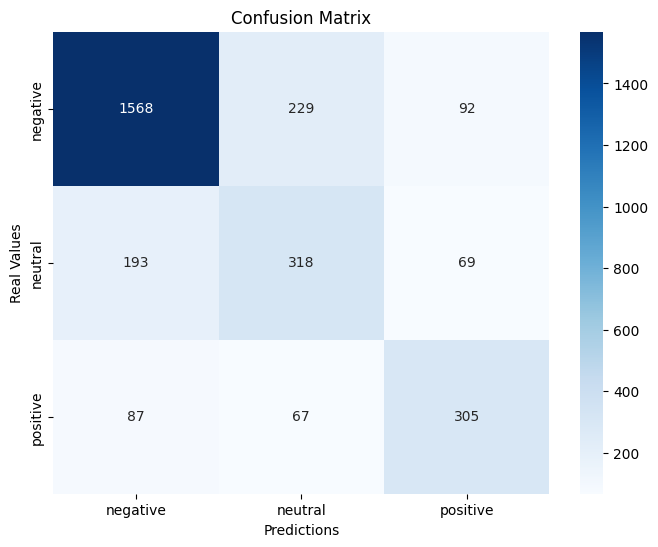

In [24]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [25]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Número da linha no X_test: 499
Original text:
americanair narrowly made standbylots snag trip
Classe real: negative
Classe predita: negative
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
[(np.str_('trip'), -0.5069391554655313), (np.str_('snag'), -0.2423889149234239), (np.str_('made'), -0.1705532144022722), (np.str_('americanair'), -0.16816410873844104), (np.str_('narrowly'), -0.12050126703796608), (np.str_('standbylots'), -0.09711562143844395)]


In [26]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
trip: -0.5069
snag: -0.2424
made: -0.1706
americanair: -0.1682
narrowly: -0.1205
standbylots: -0.0971


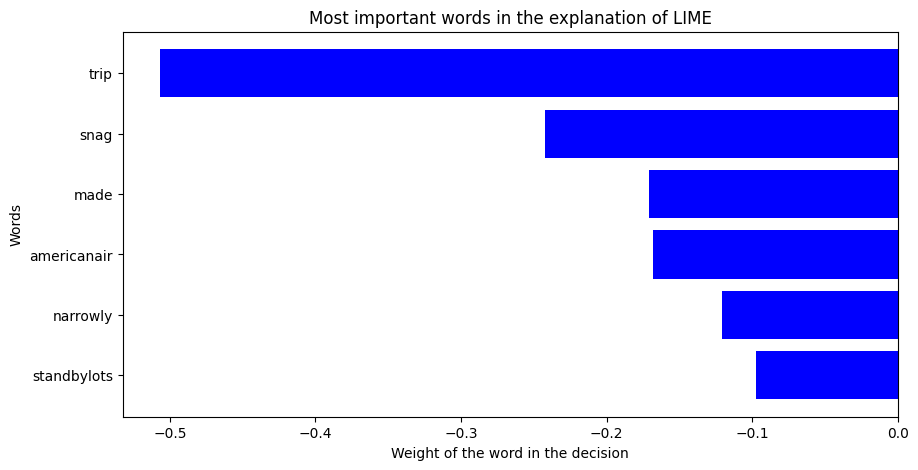

In [27]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [28]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

trip: -0.5069391554655313
snag: -0.2423889149234239
made: -0.1705532144022722
americanair: -0.16816410873844104
narrowly: -0.12050126703796608
standbylots: -0.09711562143844395


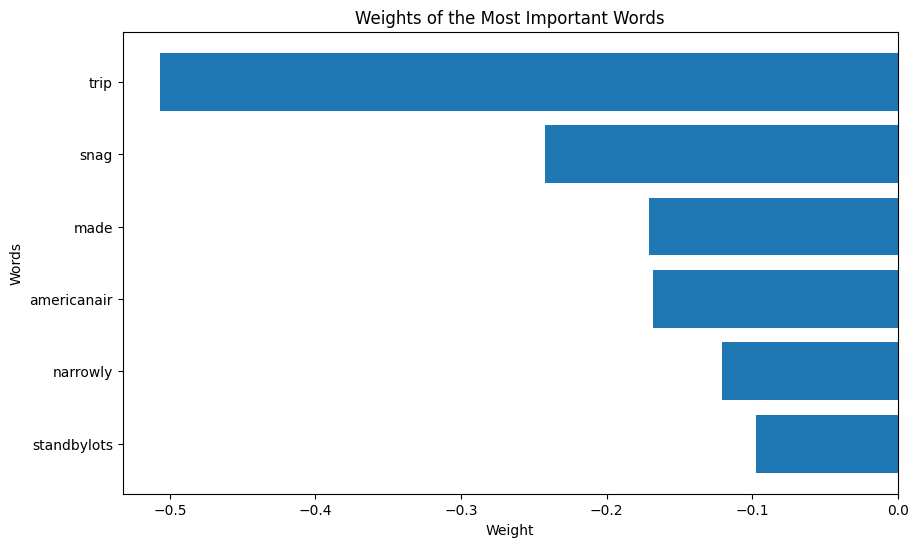

In [29]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [30]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
A classe prevista para o texto é o índice: 1

Palavras do exemplo e seus pesos na decisão da classe prevista (LSTM):
         Feature    Weight
4601     measure -0.300345
3104  technology -0.896267
2208        park -1.079869


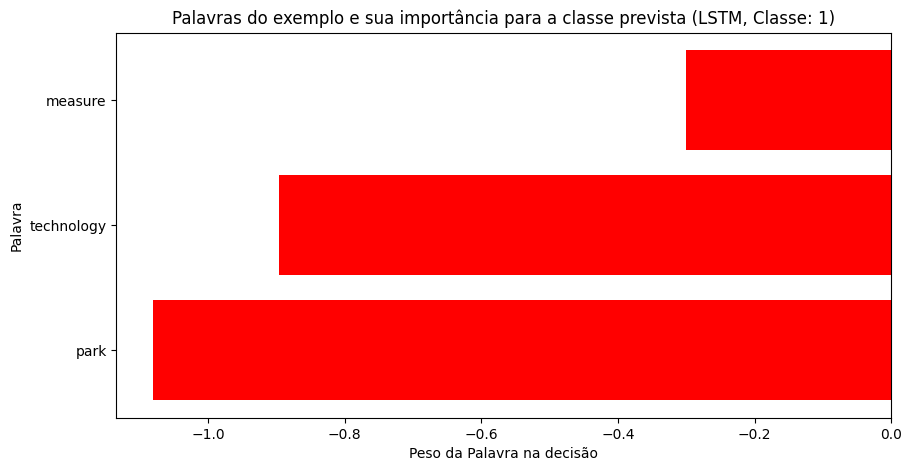

In [31]:
# Definir o texto de exemplo
sample_text = "preliminary estimation technology park measure square meter"

# **Etapa 1: Calcular a importância das palavras para cada classe do modelo LSTM**

# Obter os pesos da camada de Embedding
# Supondo que a camada de embedding é a primeira (índice 0)
embedding_weights = model.layers[0].get_weights()[0]

# Usar tokenizer.index_word para obter as palavras a partir dos índices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense (a última camada de saída)
dense_weights = model.layers[-1].get_weights()[0]

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

# **Etapa 2: Prever a classe do sample_text usando o modelo LSTM**

# O `maxlen` deve ser o mesmo usado durante o treinamento
# Assumindo que a variável `MAX_SEQUENCE_LENGTH` foi definida em uma célula anterior
# Caso contrário, defina-a aqui: MAX_SEQUENCE_LENGTH = ...
MAX_SEQUENCE_LENGTH = 100 # Substitua pelo valor correto do seu modelo

# Pré-processar o texto de exemplo para o modelo LSTM
sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Fazer a previsão
prediction = model.predict(padded_sequence)

# Obter o índice da classe prevista (a com maior probabilidade)
predicted_class_index = np.argmax(prediction[0])

print(f"A classe prevista para o texto é o índice: {predicted_class_index}")

# **Etapa 3: Visualizar a importância das palavras para a classe prevista**

# Selecionar o DataFrame de importâncias da classe prevista
importancias_da_classe_prevista = importancias_das_features[predicted_class_index]

# Criar um conjunto com as palavras do exemplo, para uma busca mais eficiente
# A regex `\b\w+\b` garante que apenas palavras sejam extraídas, ignorando pontuação
palavras_exemplo = set(re.findall(r'\b\w+\b', sample_text.lower()))

# Filtrar o DataFrame para incluir apenas as palavras que estão no texto de exemplo
importancias_exemplo_lstm = importancias_da_classe_prevista[
    importancias_da_classe_prevista['Feature'].apply(lambda x: x in palavras_exemplo)
]
importancias_exemplo_lstm = importancias_exemplo_lstm.sort_values(by='Weight', ascending=False)

# Exibir as importâncias das palavras do exemplo
print("\nPalavras do exemplo e seus pesos na decisão da classe prevista (LSTM):")
print(importancias_exemplo_lstm[['Feature', 'Weight']])

# **Etapa 4: Plotar o gráfico**

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo_lstm['Feature'], importancias_exemplo_lstm['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title(f"Palavras do exemplo e sua importância para a classe prevista (LSTM, Classe: {predicted_class_index})")
plt.gca().invert_yaxis()
plt.show()

In [32]:
# Obter os pesos da camada de Embedding
embedding_weights = model.layers[0].get_weights()[0]  # A primeira camada é a Embedding

# Using tokenizer.index_word to get words from indices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense
dense_weights = model.layers[-1].get_weights()[0]  # A última camada é a Dense

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)
# Exibir as importâncias das palavras para o mesmo exemplo usado no lime



In [33]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Peso': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Peso', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
                  Feature      Peso
61                   wait  4.153354
10              cancelled  4.053788
23                   cant  3.991037
201                  nice  3.921641
4183         pbpinftworth  3.799163
251                almost  3.653578
1084                  mad  3.589218
632               charged  3.578946
3101              present  3.554780
3393                  oak  3.540452
2523  customerservicefail  3.440768
1633                 spot  3.421142
3646       perfectomobile  3.324845
4062            oversized  3.241699
4173            typically  3.198620
2589             savannah  3.170870
4226                 thaw  3.147829
1518                 hunt  3.067547
3980               sanity  3.060971
3381           notmyfault  3.051152


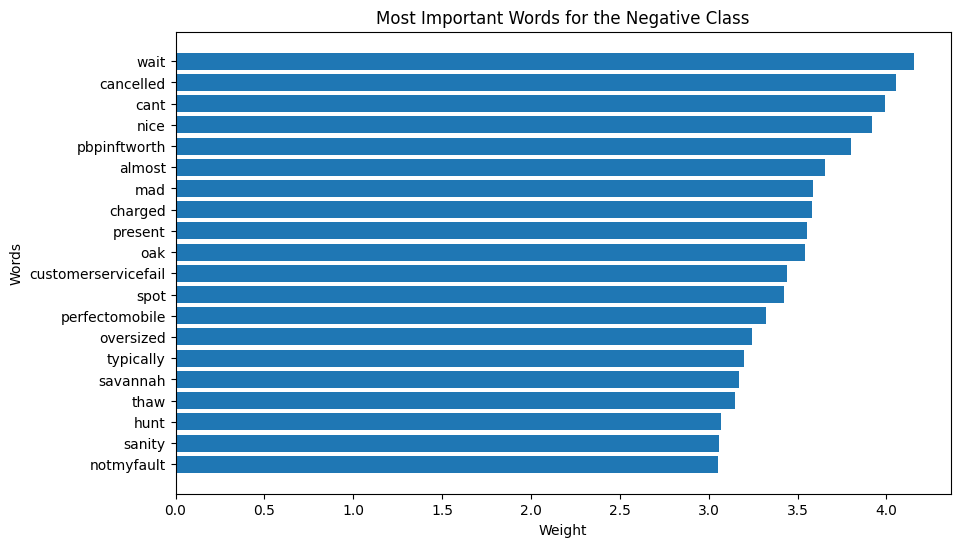

In [34]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Peso'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [35]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Peso': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Peso', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
         Feature      Peso
503         hate  2.097167
2674  usairsucks  1.868840
2126       aisle  1.744978
672         haha  1.650841
374         snow  1.641467
1192       paper  1.631527
2540   streaming  1.565759
1048        mint  1.544408
258      helpful  1.487371
257         paid  1.462744
1310      issued  1.448326
2433         cat  1.427426
2670    enjoying  1.392490
4615          in  1.378256
2313       pound  1.377373
1333        york  1.369100
3947         bff  1.340545
3192      comedy  1.338013
993    purchased  1.298853
3892    postcode  1.279520


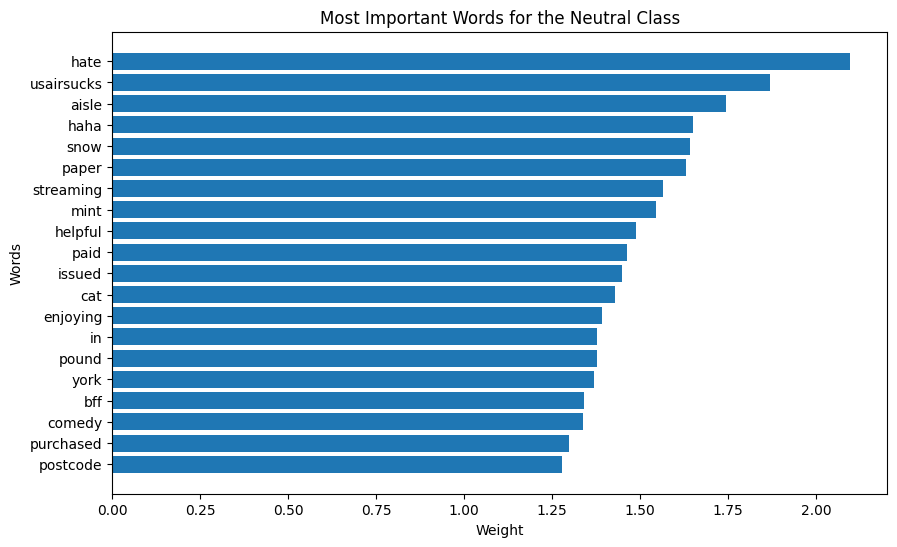

In [36]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Peso'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [37]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Peso': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Peso', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
             Feature      Peso
20               amp  5.728922
555          respond  5.437055
173            pilot  4.453887
1837          locate  4.422523
422               na  4.018909
445                k  3.789614
34     virginamerica  3.752524
74             issue  3.673069
260              pas  3.633892
502             joke  3.489380
254        southwest  3.399256
1432              ty  3.388393
4        americanair  3.376249
280              add  3.310462
5       southwestair  3.302519
490   imaginedragons  3.300590
29             would  3.268294
183             also  3.252401
711             list  3.216495
197             able  3.213943


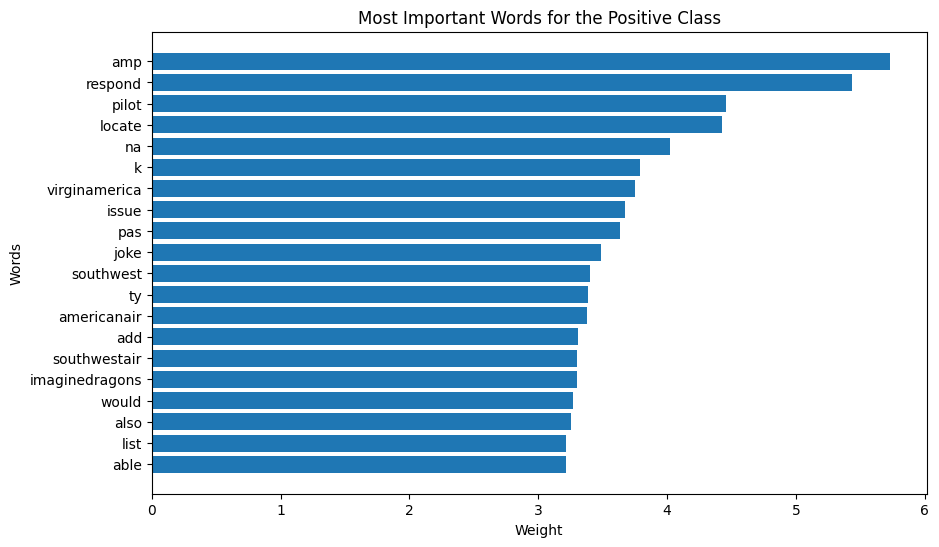

In [38]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Peso'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()